In [1]:
# Notebook to complete a SELF-SUPERVISED LEARNING task that is asked to be completed at the NYU Deep Learning - 2020
# The idea is to design a system to park a trailer backwards to a point with no forward move and minimum error
# Visit: https://tifu.github.io/truck_backer_upper/ for the full JS code. We will do the full python version here. 

# Approach:
# create a truck object, set up the environment on cartesian coordinates, set the speed, angles, and all boundaries 
# design a controller(decision maker) and emulator (truck dynamics) system with neural networks
# train the network until perfection so that the truck parks perfectly everytime starting from any angle!

import torch
import torch.nn as nn
from torch.optim import SGD
from tqdm import tqdm
from matplotlib.pylab import *  
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
π = pi  # Example: This is how to write the greek letters in jupyter notebook: \alpha + TAB ---> α
print(sin(π/2))
print(π/2) # 90 degrees


1.0
1.5707963267948966


In [2]:
style.use(['dark_background', 'bmh'])
%matplotlib notebook
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# Here are some photos from the NYU's deep learning website:

Car-trailer diagram from: https://atcold.github.io/pytorch-Deep-Learning/en/week10/10-3/
![car-trailer](truck.png)

Car-trailer equation:
\begin{align}
\dot x &= s \cos \theta_0 \\
\dot y &= s \sin \theta_0 \\
\dot \theta_0 &= \frac{s}{L} \tan \phi \\
\dot \theta_1 &= \frac{s}{d_1} \sin(\theta_1 - \theta_0)
\end{align}
where $s$: signed speed, $\phi$: negative steering angle,

Car-trailer diagram-2 from :https://atcold.github.io/pytorch-Deep-Learning/en/week10/10-3/
![car-trailer](system2.png)    

System to be designed from :https://atcold.github.io/pytorch-Deep-Learning/en/week10/10-3/
![network system](system.png)  

In [3]:
# Simplify the above emulator architecture and downgrade the 6 attributes to 4 attributes since 2 attributes depend
# on the other attributes. Create Truck class and make truck.step(steering_angle) function move one step backwards.
# truck.step(steering_angle) function is going to be emulator's job and controller will decide which step to take next

class Truck:
    def __init__(self, target = False, display=False):
        
        self.target = target
        self.W = 1  # car and trailer width, for drawing only
        self.L = 1 * self.W  # car length
        self.d = 4 * self.L  # d_1
        self.s = -0.1  # speed
        self.display = display
        self.box = [-1, 40, -20, 20] # the box is made with coordinates of x0, x1, y0, y1 with intersection visable at 0
        if self.display:
            self.f = figure(figsize=(10, 5), num='The truck backer-upper', facecolor='none') # display figsize
            self.ax = self.f.add_axes([0.01, 0.01, 0.98, 0.98], facecolor='black') # fill in the whole box space
            self.patches = list()    
            self.ax.axis('equal')
            b = self.box
            self.ax.axis([b[0], b[1], b[2], b[3]]) 
            self.ax.set_xticks([], []); self.ax.set_yticks([], []) # not to display any ticks
            self.ax.axhline(); self.ax.axvline() 
    
                
        if self.target == False:
            self.reset()
            # Example: self.x, self.y, self.θ0, self.θ1 = 17.25, -4.49, 3.89, 4.0
        else:
            # target:
            self.x, self.y, self.θ0, self.θ1 = 4, 0, 0, 0
            self.ϕ = 0
            self.draw()
        
        
    def reset(self, ϕ=0):
        self.ϕ = ϕ  # car initial steering angle
        
        # self.θ0 = deg2rad(30)  # car initial direction
        # self.θ1 = deg2rad(-30)  # trailer initial direction
        # self.x, self.y = 20, -5  # initial car coordinates
        
        self.θ0 = random() * 2 * π  # 0 <= ϑ₀ < 2π 
        self.θ1 = (random() - 0.5) * π / 2 + self.θ0  # -π/4 <= ϑ₁ - ϑ₀ < π/4
        self.x = 10 + random() * (self.box[1] - 20) # somewhere between 10 - 30
        self.y = (random() - tanh(random())) * self.box[3]/2 # (somewhere between -15 and 15)

            
        # If poorly initialise, then re-initialise
        if not self.valid():
            self.reset(ϕ)
        
        # Draw, if display is True
        if self.display: self.draw()
    
    def step(self, ϕ=0, dt=1):
        
        # Check for illegal conditions
        if self.is_jackknifed():
            print('The truck is jackknifed!')
            return
        
        if self.is_offscreen():
            print('The car or trailer is off screen')
            return
        
        x, y, W, L, d, s, θ0, θ1, _ = self._get_atributes() # a new step steering signal will be added to the system
        self.ϕ = ϕ # for sensitivity purposes, the steering angle can be multiplied with a coefficient

        # Perform state update
        self.x += s * cos(θ0) * dt
        self.y += s * sin(θ0) * dt
        self.θ0 += s / L * tan(self.ϕ) * dt
        self.θ1 += s / d * sin(θ0 - θ1) * dt
        
        # return (self.x, self.y, self.θ0, *self._trailer_xy(), self.θ1)
        return (self.x, self.y, self.θ0, self.θ1)
    
    def state(self):
        return (self.x, self.y, self.θ0, self.θ1)
    
    def _get_atributes(self):
        return (
            self.x, self.y, self.W, self.L, self.d, self.s,
            self.θ0, self.θ1, self.ϕ
        )
    
    def _trailer_xy(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return x - d * cos(θ1), y - d * sin(θ1)
        
    def is_jackknifed(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        return abs(θ0 - θ1) * 180 / π > 90
    
    def is_offscreen(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        
        x1, y1 = x + 1.5 * L * cos(θ0), y + 1.5 * L * sin(θ0)
        x2, y2 = self._trailer_xy()
        
        b = self.box
        return not (
            b[0] <= x1 <= b[1] and b[2] <= y1 <= b[3] and
            b[0] <= x2 <= b[1] and b[2] <= y2 <= b[3]
        )
        
    def valid(self):
        return not self.is_jackknifed() and not self.is_offscreen()
        
    def draw(self):
        if not self.display: return
        if self.patches: self.clear()
        self._draw_car()
        self._draw_trailer()
        self.f.canvas.draw()
        # this is how to draw an empty canvas: fig, ax = plt.subplots()  and then type fig.canvas.draw() 
            
    def clear(self):
        for p in self.patches:
            p.remove()
        self.patches = list()
        
    def _draw_car(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
        
        x1, y1 = x + L / 2 * cos(θ0), y + L / 2 * sin(θ0)
        bar = Line2D((x, x1), (y, y1), lw=5, color='C2', alpha=0.8)
        ax.add_line(bar)

        car = Rectangle(
            (x1, y1 - W / 2), L, W, 0, color='C2', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x1, y1, θ0 * 180 / π) +
            ax.transData
        )
        ax.add_patch(car)

        x2, y2 = x1 + L / 2 ** 0.5 * cos(θ0 + π / 4), y1 + L / 2 ** 0.5 * sin(θ0 + π / 4)
        left_wheel = Line2D(
            (x2 - L / 4 * cos(θ0 + ϕ), x2 + L / 4 * cos(θ0 + ϕ)),
            (y2 - L / 4 * sin(θ0 + ϕ), y2 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(left_wheel)

        x3, y3 = x1 + L / 2 ** 0.5 * cos(π / 4 - θ0), y1 - L / 2 ** 0.5 * sin(π / 4 - θ0)
        right_wheel = Line2D(
            (x3 - L / 4 * cos(θ0 + ϕ), x3 + L / 4 * cos(θ0 + ϕ)),
            (y3 - L / 4 * sin(θ0 + ϕ), y3 + L / 4 * sin(θ0 + ϕ)),
            lw=3, color='C5', alpha=1)
        ax.add_line(right_wheel)
        
        self.patches += [car, bar, left_wheel, right_wheel]
        
    def _draw_trailer(self):
        x, y, W, L, d, s, θ0, θ1, ϕ = self._get_atributes()
        ax = self.ax
            
        x, y = x - d * cos(θ1), y - d * sin(θ1) - W / 2
        trailer = Rectangle(
            (x, y), d, W, 0, color='C0', alpha=0.8, transform=
            matplotlib.transforms.Affine2D().rotate_deg_around(x, y + W/2, θ1 * 180 / π) +
            ax.transData
        )
        ax.add_patch(trailer)
        
        self.patches += [trailer]

In [4]:
# view the final position that the truck should be arriving
# truck = Truck(target = True, display=True)
# print(truck.state()) 
tan(-0.5)

-0.5463024898437905

In [5]:
# View the state of a random position that the truck is initiated

truck = Truck(target = False, display=False)
print(truck.state()) 

(19.914746941413455, 1.413578958369831, 4.104251324177204, 4.051303157527335)


In [6]:
truck.reset()
# * 180 / π > 90
ϕ = deg2rad(-45)  # positive means left, negative means right
ϕ2 = deg2rad(45)
print(abs(ϕ  - ϕ2))
print(abs(ϕ  - ϕ2)*180/π)
print(ϕ,ϕ2)
# print(ϕ_state)
for i in range(10):
    truck.step(ϕ)
truck.draw()
x, y, W, L, d, s, θ0, θ1, ϕ = truck._get_atributes()
print( x, y, W, L, d, s, θ0, θ1, ϕ)
# β = max(θ0, θ1) should be (abs(ϕ  - ϕ2)*180/π) 90 degrees. 
print('state', truck.state())

1.5707963267948966
90.0
-0.7853981633974483 0.7853981633974483
20.097590028333542 3.302888937371609 1 1 4 -0.1 6.112590512083578 5.794325096328856 -0.7853981633974483
state (20.097590028333542, 3.302888937371609, 6.112590512083578, 5.794325096328856)


In [7]:
truck.reset()

In [8]:
# UNMARK this cell to create emulator dataset and run it

# Build emulator dataset
# truck.step(ϕ) and truck.state() both returns (self.x, self.y, self.θ0, self.θ1)

# episodes = 100000
# inputs = np.zeros([episodes, 5])
# outputs = np.zeros([episodes, 4])
# truck = Truck() 

# for episode in tqdm(range(episodes)): # Instantly make your loops show a smart progress meter with tqdm
#     truck.reset()
#     if truck.valid():
#         truck.reset()
#         initial_state = truck.state()
#         steering_signal = (random() - 0.5) * π / 2
#         inputs[episode][0] = steering_signal 
#         inputs[episode][1:] = initial_state
#         output_state = truck.step(ϕ)
#         outputs[episode] = output_state 
# print(inputs[:5], outputs[:5])

In [9]:
# # UNMARK this cell to view the inputs

# print(len(inputs), len(outputs), initial_state)
# init = truck.state()
# print(init)
# print(truck.ϕ, truck.θ0, truck.θ1)
# print(type(truck.θ0))
# # ( x, y, W, L, d, s, θ0, θ1, ϕ) : truck attributes
# # def state(self): return (self.x, self.y, self.θ0, self.θ1) : truck state
# # def _trailer_xy(self): return x - d * cos(θ1), y - d * sin(θ1)
# # ideal state: 4, 0, 0, 0

In [10]:
# Create the emulator

state_size = 4
steering_size = 1
hidden_units_e = 50

emulator = nn.Sequential(
    nn.Linear(steering_size + state_size, hidden_units_e),
    nn.ReLU(),
    nn.Linear(hidden_units_e, state_size)
)

optimiser_e = SGD(emulator.parameters(), lr=0.001)
criterion = nn.MSELoss()
emulator.to(device)

Sequential(
  (0): Linear(in_features=5, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=4, bias=True)
)

In [11]:
# UNMARK this cell to normalize the training set

# # Normalize the inputs and outputs to train the emulator

# tensor_inputs = torch.Tensor(inputs).to(device)
# tensor_outputs = torch.Tensor(outputs).to(device)
# print(tensor_inputs[0], tensor_outputs[0])
# mean = tensor_inputs.mean(0)
# std = tensor_inputs.std(0)
# tensor_inputs = (tensor_inputs - mean) / std
# tensor_outputs = (tensor_outputs - mean[1:]) / std[1:]

In [12]:
# UNMARK this cell to split the training set into testing and training sets

# # Split the data into 90:10 for test:train.
# test_size = int(len(tensor_inputs) * 0.9)
# print(len(tensor_inputs), test_size)

# train_inputs = tensor_inputs[:test_size]
# train_outputs = tensor_outputs[:test_size]
# test_inputs = tensor_inputs[test_size:]
# test_outputs = tensor_outputs[test_size:]

In [13]:
# # UNMARK this cell to train the emulator if you are not uploading the trained weights.

# cnt = 0
# for i in torch.randperm(len(train_inputs)):
#     ϕ_state = train_inputs[i]
#     next_state_prediction = emulator(ϕ_state)
    
#     next_state = train_outputs[i]
#     loss = criterion(next_state_prediction, next_state)
    
#     optimiser_e.zero_grad()
#     loss.backward()
#     optimiser_e.step()
    
#     if cnt == 0 or (cnt + 1) % 10000 == 0:
#         print(f'{cnt + 1:4d} / {len(train_inputs)}, {loss.item():.10f}')
#     cnt += 1

In [14]:
# UNMARK this cell to test the emulator

# # Test
# total_loss = 0
# with torch.no_grad():
#     for idx, ϕ_state in enumerate(test_inputs):
#         next_state_prediction = emulator(ϕ_state)
#         next_state = test_outputs[idx]
#         total_loss += criterion(next_state_prediction, next_state).item()

# ave_test_loss = total_loss/test_size
# print(f'Test loss: {ave_test_loss:.10f}')

# truck.step(ϕ) at truck_state: x,y,θ0,θ1 is now very similar to emulator(ϕ,x,y,θ0,θ1)

In [15]:
# Create the controller

# truck.reset()
# print(truck.state())
# print(ϕ_state) # print the input state with length 5 
# print(emulator(ϕ_state)) # outputs an array with length 4 ((self.x, self.y, self.θ0, self.θ1))

# create the controller

state_size = 4
steering_size = 1
hidden_units_c = 50

controller = nn.Sequential(
    nn.Linear(state_size, hidden_units_c),
    nn.ReLU(),
    nn.Linear(hidden_units_c, steering_size)
)

optimiser_c = SGD(controller.parameters(), lr=0.01)
criterion = nn.MSELoss()
controller.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)

In [16]:
# UNMARK this cell to view the outputs of the emulator and controller

# # Check if all dimensions are matching, see if there are exploding gradients

# truck = Truck(display=False)
# emulator_output = emulator(ϕ_state) # dim 5 --> dim 4 
# print(type(emulator_output))
# steering_signal = controller(emulator_output) # dim 4 --> dim 1
# print(emulator_output, steering_signal)
# z = torch.cat((emulator_output, steering_signal), dim = 0, out= None)
# # print(z)
# z2 = emulator(z)
# # print(ϕ_state, z2)
# truck.state()

In [17]:
# UNMARK this cell and train it if you are not uploading the trained weights.

# # train the model's controller together with the trained emulator while its grads are frozen
# # reminder: (self.x, self.y, self.θ0, self.θ1) is the truck.state
# # reminder: (steering_signal, self.x, self.y, self.θ0, self.θ1) is the emulator input state
# torch.autograd.set_detect_anomaly(True)
# ideal_input_state = torch.tensor([0,4,0,0,0]) # dimension (5,) where steering angle:0, x:4, y:0, carϕ:0, truckϕ:0 
# ideal_input_state.unsqueeze(0) # add dimension 
# ideal_input_state = ideal_input_state.to(torch.float32).to(device) # make it float
# # initial state is a random entry. example:
# # ϕ_state = torch.tensor([ 0.0016, -0.8850,  1.4821,  0.8605, -0.3474,  1.4624,  0.1244], requires_grad=True)
# truck = Truck(display=False)
# new_state = True # this is to re-iterate and old state as if it is a new state
# loss = np.inf
# error = np.inf
# # train the system
# for i in tqdm(range(len(train_inputs))): # max 1 epoch only
#     input_state = train_inputs[i].to(device)
#     error = criterion(ideal_input_state, input_state) 
#     if new_state == False or error < 0.1: # need more training this instance, the error is getting smaller, do not jump to the next one yet
#         input_state = last_saved_state 
#     for j in range(100): # see if the truck can continue to make the right steps until it reaches to the origin 
#         with torch.no_grad():  # freeze the weights of the emulator network
#             emulator_output = emulator(input_state).to(device) # dim 5 --> dim 4 with no grads coming from the 2 layer network
#         steering_signal = controller(emulator_output).to(device) # dim 4 --> dim 1
#         steering_signal_no_grads = steering_signal.clone().detach()
#         # move the truck one step with the signal coming from controller if emulator is not used above truck.step() will do the same job
#         # truck.step(steering_signal_no_grads) will return (self.x, self.y, self.θ0, self.θ1)
#         # place the new steering signal into the next state that has grads coming from the controller
#         ϕ_next_state = torch.cat((steering_signal, emulator_output), dim= 0).to(device) # (5,)
#         # obtain the next input state with no grads that will be fed to the emulator
#         input_state = torch.cat((steering_signal_no_grads, emulator_output), dim= 0) # (5,)
#         truck.x, truck.y, truck.θ0, truck.θ1 = emulator_output
#         # manual improvements - 1
#         # punish the mistaken signals as soon as truck is not in a good position
#         dangerous_angle = abs(truck.θ0 - truck.θ1) * 180 / π > 80 # ready to get jacknifed soon
#         # manual improvements - 2
#         # x and y coordinates of the trailer
#         trailer_state_x = truck.x - 4 * torch.cos(truck.θ1)  
#         trailer_state_y = truck.y - 4 * torch.sin(truck.θ1)
#         x_screen_out = trailer_state_x < 8 or trailer_state_x > 35
#         y_screen_out = trailer_state_y < -15 or trailer_state_y > 15
#         # if not truck.valid(): # use this for larger epochs and fine tuning, without the manual improvements
#         # if the conditions get worse, jump to the loss calculations, update the parameters 
#         if not truck.valid() or dangerous_angle or (x_screen_out and y_screen_out): 
#             loss = criterion(ϕ_next_state, ideal_input_state) 
#             optimiser_c.zero_grad()
#             loss.backward() # retain_graph=True if emulator was not frozen
#             optimiser_c.step()
#             new_state = True
#             break
#         error = criterion(ϕ_next_state, ideal_input_state) 
#         # if it is going well, do not update the weights until 10 consequtive steps 
#         if j % 50 == 0:
#             loss = criterion(ϕ_next_state, ideal_input_state).to(device)
#             optimiser_c.zero_grad()
#             loss.backward(retain_graph=True) # retain_graph=True would be active if emulator was not frozen
#             optimiser_c.step()
#         if j % 99 == 0 and error > 0.05: # made it all the way here but it is not at the spot yet, continue with the last state
#             last_saved_state = input_state
#             new_state == False
#         if error < 0.05: # reached the target with this instance, move to the next experiment
#             new_state == True 

# #     if i % 500 == 0:
# #         print(i , 'of', episodes) # see the progress of training
  
# # save emulator and controller weights.


In [18]:
# test the model 
# print(ϕ_state) 
# print(truck.state())
# truck = Truck(display=True)
# truck.draw()



In [19]:
# UNMARK this cell and see the performace of the controller and emulator

# truck = Truck(display=False)
# for j in range(10): # number of trials
#     truck.reset()
#     # instantiate the truck object
#     truck.draw() # uncomment to view the training but make sure to set the number of episodes to a small value
#     init_truck_state = truck.state()
#     init_truck_state = torch.tensor(init_truck_state)
#     init_truck_state.unsqueeze(0)
#     init_truck_state = init_truck_state.to(torch.float32)
#     for i in range(1500): # 1000 steps
#         with torch.no_grad():
#             controller_output = controller(init_truck_state)
#             emulator_input = torch.cat((controller_output, init_truck_state), dim = 0)
#             emulator_output = emulator(emulator_input)
#             truck.x, truck.y, truck.θ0, truck.θ1 = emulator_output
#             init_truck_state = emulator_output
#         truck.draw()
#         if not truck.valid():
#             print('not valid')
#             break
    
#     print(truck.state())

In [20]:
torch.save(controller.state_dict(),'controller.txt')
torch.save(emulator.state_dict(),'emulator.txt')

In [24]:
# Upload the trained parameters that is from all the training in the above cells

trained_emulator = emulator
trained_emulator.load_state_dict(torch.load('emulator.txt'))
print(list(trained_emulator.named_parameters()))
trained_emulator.eval()

trained_controller = controller
trained_controller.load_state_dict(torch.load('controller.txt'))
print(list(trained_controller.named_parameters()))
trained_controller.eval()


[('0.weight', Parameter containing:
tensor([[-3.2098e-01,  3.3762e-01, -3.2138e-01, -3.9596e-01,  3.5936e-01],
        [-2.4258e-01,  1.5048e-01,  3.2251e-01,  3.3891e-01,  1.0066e-01],
        [-1.6079e-01, -2.3152e-01,  4.3720e-01, -2.1521e-01,  1.9349e-01],
        [ 2.6046e-01, -9.8580e-03, -3.2245e-01, -6.2931e-02,  9.9391e-02],
        [-6.1371e-03,  7.5847e-02,  6.1653e-02,  1.0360e-01,  2.2082e-01],
        [-3.9595e-01,  2.3252e-01,  1.8547e-01, -3.1497e-02,  1.2230e-02],
        [-1.0918e-01,  9.8330e-02, -3.3035e-01,  3.0302e-01,  4.1195e-01],
        [ 3.3235e-01,  1.9421e-01, -7.5468e-02,  5.1036e-03,  5.8475e-03],
        [ 9.0188e-02,  1.3630e-02,  1.6582e-01, -1.6240e-01, -2.9422e-01],
        [-2.4572e-02,  1.1345e-01,  1.4255e-01, -3.5515e-01,  3.4893e-01],
        [-3.9297e-01, -1.7544e-01, -3.6094e-01,  3.4854e-01,  2.7814e-01],
        [-3.8603e-01, -9.0022e-02,  1.1442e-01,  2.3131e-01,  4.1772e-02],
        [-3.1521e-01,  2.5057e-01, -1.4708e-01, -5.7213e-02,  2.

Sequential(
  (0): Linear(in_features=4, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)

<IPython.core.display.Javascript object>


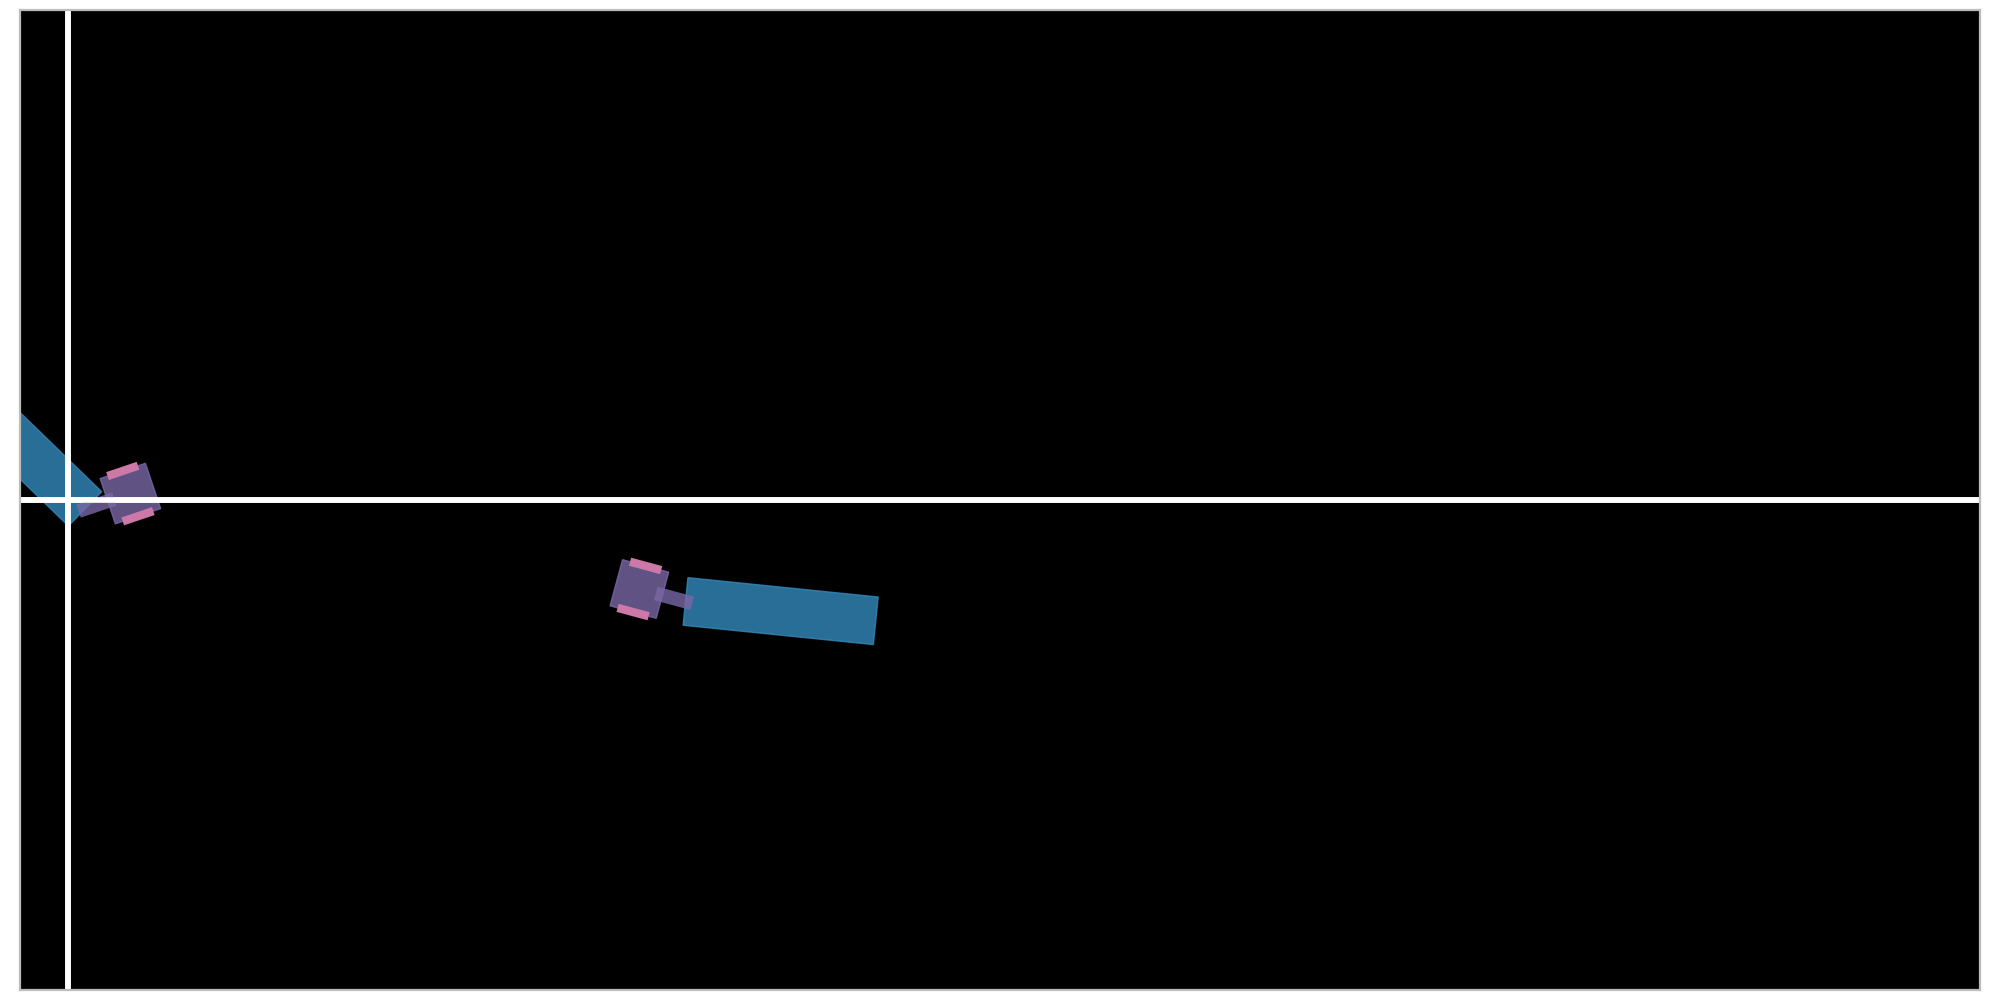

/Users/volkansonmez/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/Users/volkansonmez/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


starting position (25.318612410973795, 8.514505137433213, 5.088271704244514, 5.203288464574758)
error at starting position tensor(144.9862)
ending position (tensor(0.3617), tensor(-0.1854), tensor(0.3252), tensor(-0.7701))
error at ending position tensor(3.4927)


In [22]:
# test the trained controller and emulator

truck = Truck(display=True) # instantiate the truck object
truck.draw() 
init_truck_state = truck.state()
print('starting position', init_truck_state)

init_truck_state = torch.tensor(init_truck_state)
init_truck_state.unsqueeze(0)
init_truck_state = init_truck_state.to(torch.float32)

ideal_arrival_coor = torch.tensor([4,0,0,0]) # dimension (5,) where steering angle:0, x:4, y:0, carϕ:0, truckϕ:0 
ideal_arrival_coor.unsqueeze(0) # add dimension 
ideal_arrival_coor = ideal_arrival_coor.to(torch.float32) # make it float

error = criterion(ideal_arrival_coor,init_truck_state) 
print('error at starting position', error) 

while error > 4.0: # average a few hundred steps to reach at this error level if truck is created around the middle
    with torch.no_grad():
        controller_output = trained_controller(init_truck_state)
        emulator_input = torch.cat((controller_output, init_truck_state), dim = 0)
        emulator_output = trained_emulator(emulator_input)
        truck.x, truck.y, truck.θ0, truck.θ1 = emulator_output
        init_truck_state = emulator_output
    truck.draw()
    if not truck.valid():
        break
print('ending position', truck.state()) 
error = criterion(ideal_arrival_coor,init_truck_state) 
print('error at ending position', error) 


# NOTES:
    
# 4,0,0,0 is the ideal ending position for truck.x, truck.y, truck.θ0, truck.θ1 
# train the model more and make it more complex for better precision.
# fix the movement quality by adding the truck_xy features. it is not moving backwards perfectly but sliding.


# EXAMPLE TEST:

# starting position (21.825327976519127, -5.734001415620186, 2.524479989623713, 2.885350440041539)
# error at starting position tensor(91.3298)
# ending position (tensor(7.0977), tensor(2.3766), tensor(3.6527), tensor(2.0318))
# error at ending position tensor(8.1785)


In [23]:
truck = Truck(display=True) # instantiate the truck object to view starting position
truck.draw() 

/Users/volkansonmez/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/volkansonmez/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
/Users/volkansonmez/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
